In [1]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
def load_images_from_folder(folder, label, target_size=(224, 224)):
    data = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        try:
            img = Image.open(file_path).convert('RGB')
            img = img.resize(target_size)  # Resize the image to target size
            data.append((np.array(img), label))
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    return data

positive_folder = "positive"
negative_folder = "negative"

positive_images = load_images_from_folder(positive_folder, label=1)
negative_images = load_images_from_folder(negative_folder, label=0)

In [5]:
all_image_data = positive_images + negative_images
random.shuffle(all_image_data)

X = np.array([item[0] for item in all_image_data])
y = np.array([item[1] for item in all_image_data])

X = X / 255.0  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Convert training and testing data into TensorFlow datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

#Load the VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (so its weights are not updated during training)
base_model.trainable = False

In [13]:
model = Sequential([
    data_augmentation,  # Apply data augmentation
    base_model,  # Pre-trained VGG16 as the base model
    GlobalAveragePooling2D(),  # Replace the Flatten layer for better generalization
    Dense(128, activation='relu'),  # Add a dense layer for learning
    Dropout(0.5),  # Add dropout to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
epochs = 20
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 184s 23s/step - accuracy: 0.4169 - loss: 2.0370 - val_accuracy: 0.6102 - val_loss: 0.8514
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 190s 22s/step - accuracy: 0.7051 - loss: 0.8529 - val_accuracy: 0.7797 - val_loss: 0.7349
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 170s 22s/step - accuracy: 0.7423 - loss: 0.6855 - val_accuracy: 0.7966 - val_loss: 0.6602
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 177s 23s/step - accuracy: 0.8607 - loss: 0.3775 - val_accuracy: 0.7627 - val_loss: 0.6454
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 144s 18s/step - accuracy: 0.8525 - loss: 0.3407 - val_accuracy: 0.8136 - val_loss: 0.6088
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - accuracy: 0.8617 - loss: 0.3498 - val_accuracy: 0.8136 - val_loss: 0.5242
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 99s 13s/step - accuracy: 0.9131 - loss: 0.2637 - val_accuracy: 0.7797 - val_loss: 0.4926
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 98s 13s/step - accuracy: 0.9136 - loss: 0.2228 - val_accuracy: 0.8475 - val_loss: 0.

In [17]:
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"\nTraining Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

# Evaluate on testing data
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Testing Loss: {test_loss:.4f} | Testing Accuracy: {test_accuracy:.4f}")

# Get predictions on training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Training Metrics ===")
print("Accuracy:  ", accuracy_score(y_train, y_train_pred))
print("Precision: ", precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("\nClassification Report (Training Data):")
print(classification_report(y_train, y_train_pred, zero_division=0))

# Get predictions on testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Testing Metrics ===")
print("Accuracy:  ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("\nClassification Report (Testing Data):")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Function to plot interactive confusion matrix
def plot_confusion_matrix_interactive(cm, title):
    labels = ['Negative', 'Positive']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    fig = px.imshow(cm_df, text_auto=True, aspect="auto",
                    labels=dict(x="Predicted Label", y="True Label", color="Count"),
                    title=title, color_continuous_scale='Viridis')
    fig.update_xaxes(side="bottom")
    fig.show()

# Compute and plot confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Data):")
print(cm_test)
plot_confusion_matrix_interactive(cm_test, "Interactive Confusion Matrix - Testing Data")



Training Loss: 0.1029 | Training Accuracy: 0.9742
Testing Loss: 0.2983 | Testing Accuracy: 0.8983
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step

=== Training Metrics ===
Accuracy:   0.9742489270386266
Precision:  0.9756284488044143
Recall:     0.9742489270386266
F1-Score:   0.97429179468746

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       127
           1       0.95      1.00      0.97       106

    accuracy                           0.97       233
   macro avg       0.97      0.98      0.97       233
weighted avg       0.98      0.97      0.97       233

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step

=== Testing Metrics ===
Accuracy:   0.8983050847457628
Precision:  0.9143621766280107
Recall:     0.8983050847457628
F1-Score:   0.8963075060532687

Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        27
           1   

NameError: name 'px' is not defined

In [19]:
for layer in base_model.layers:
    # Set layers before 'block5_conv1' to non-trainable
    if layer.name == 'block5_conv1':
        break
    layer.trainable = False

# Fine-tune the remaining layers
base_model.trainable = True

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Reduced learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 10
history_fine = model.fit(train_dataset, validation_data=test_dataset, epochs=fine_tune_epochs)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 317s 38s/step - accuracy: 0.9646 - loss: 0.1531 - val_accuracy: 0.8814 - val_loss: 0.3159
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 315s 40s/step - accuracy: 0.9534 - loss: 0.0771 - val_accuracy: 0.8814 - val_loss: 0.7371
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 296s 37s/step - accuracy: 0.9583 - loss: 0.1832 - val_accuracy: 0.8983 - val_loss: 0.3533
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 317s 40s/step - accuracy: 0.9622 - loss: 0.1282 - val_accuracy: 0.8983 - val_loss: 0.3624
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 321s 40s/step - accuracy: 0.9549 - loss: 0.1231 - val_accuracy: 0.8983 - val_loss: 0.2588
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 319s 40s/step - accuracy: 0.9540 - loss: 0.1034 - val_accuracy: 0.8983 - val_loss: 0.2547
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 306s 38s/step - accuracy: 0.9833 - loss: 0.0548 - val_accuracy: 0.8983 - val_loss: 0.3369
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 309s 39s/step - accuracy: 0.9912 - loss: 0.0624 - val_accuracy: 0.8983 - val_loss:

In [23]:
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"\nTraining Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

# Evaluate on testing data
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Testing Loss: {test_loss:.4f} | Testing Accuracy: {test_accuracy:.4f}")

# Get predictions on training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Training Metrics ===")
print("Accuracy:  ", accuracy_score(y_train, y_train_pred))
print("Precision: ", precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("\nClassification Report (Training Data):")
print(classification_report(y_train, y_train_pred, zero_division=0))

# Get predictions on testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Testing Metrics ===")
print("Accuracy:  ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("\nClassification Report (Testing Data):")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Function to plot interactive confusion matrix
def plot_confusion_matrix_interactive(cm, title):
    labels = ['Negative', 'Positive']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    fig = px.imshow(cm_df, text_auto=True, aspect="auto",
                    labels=dict(x="Predicted Label", y="True Label", color="Count"),
                    title=title, color_continuous_scale='Viridis')
    fig.update_xaxes(side="bottom")
    fig.show()

# Compute and plot confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Data):")
print(cm_test)
plot_confusion_matrix_interactive(cm_test, "Interactive Confusion Matrix - Testing Data")


Training Loss: 0.0201 | Training Accuracy: 0.9914
Testing Loss: 0.4027 | Testing Accuracy: 0.9492
8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step

=== Training Metrics ===
Accuracy:   0.9914163090128756
Precision:  0.9915752662533779
Recall:     0.9914163090128756
F1-Score:   0.9914223574526009

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       127
           1       0.98      1.00      0.99       106

    accuracy                           0.99       233
   macro avg       0.99      0.99      0.99       233
weighted avg       0.99      0.99      0.99       233

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step

=== Testing Metrics ===
Accuracy:   0.9491525423728814
Precision:  0.949527873256687
Recall:     0.9491525423728814
F1-Score:   0.9490639836658386

Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1  

NameError: name 'px' is not defined

8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step


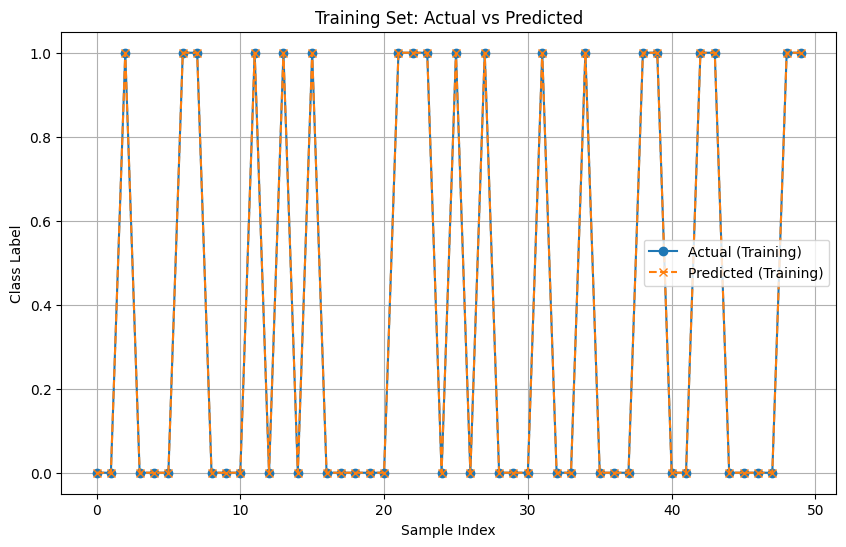

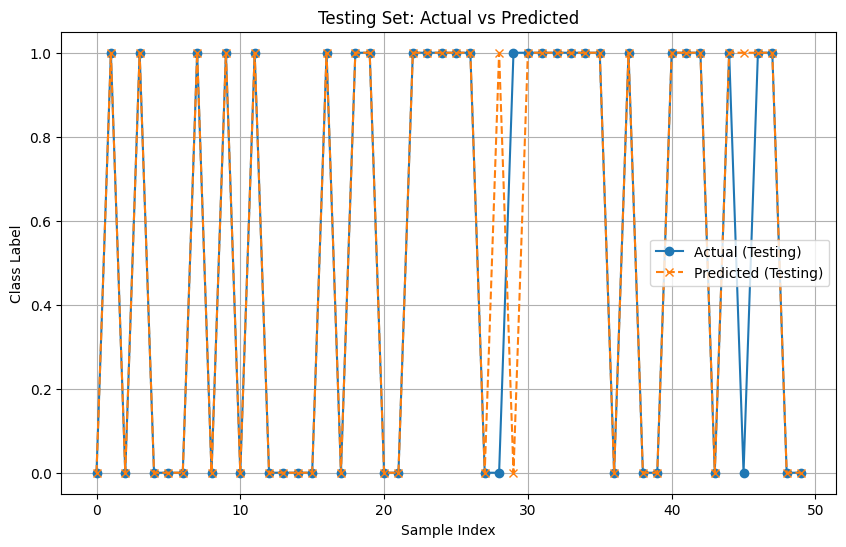

In [25]:
import matplotlib.pyplot as plt
import numpy as np

y_train_pred = model.predict(X_train)
y_train_pred_binary = [1 if p >= 0.5 else 0 for p in y_train_pred]  

y_test_pred = model.predict(X_test)
y_test_pred_binary = [1 if p >= 0.5 else 0 for p in y_test_pred] 

# Plot actual vs. predicted for the training set
plt.figure(figsize=(10, 6))
plt.plot(y_train[:50], label="Actual (Training)", marker='o', linestyle='-')  # First 50 samples
plt.plot(y_train_pred_binary[:50], label="Predicted (Training)", marker='x', linestyle='--')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid()
plt.show()

# Plot actual vs. predicted for the testing set
plt.figure(figsize=(10, 6))
plt.plot(y_test[:50], label="Actual (Testing)", marker='o', linestyle='-')  # First 50 samples
plt.plot(y_test_pred_binary[:50], label="Predicted (Testing)", marker='x', linestyle='--')
plt.title("Testing Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step


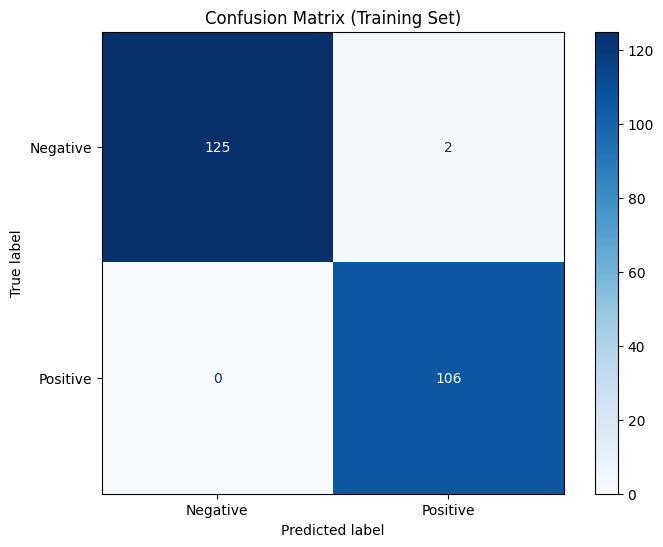

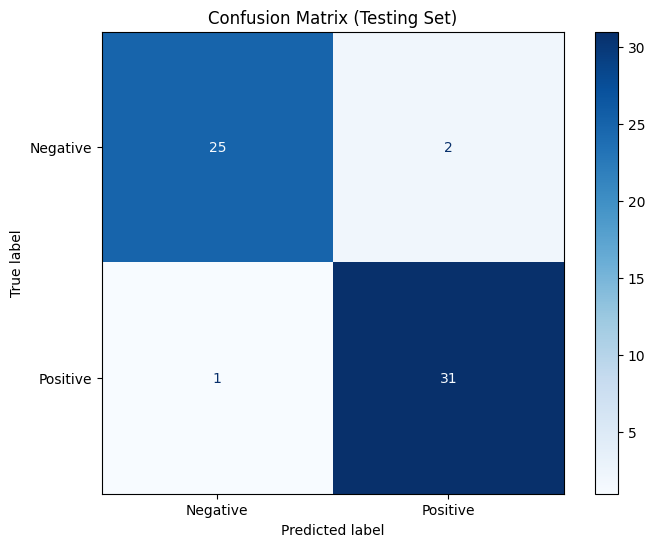

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
y_train_pred_binary = [1 if p >= 0.5 else 0 for p in y_train_pred]

y_test_pred = model.predict(X_test)
y_test_pred_binary = [1 if p >= 0.5 else 0 for p in y_test_pred]

train_cm = confusion_matrix(y_train, y_train_pred_binary)
test_cm = confusion_matrix(y_test, y_test_pred_binary)

plt.figure(figsize=(8, 6))
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["Negative", "Positive"])
train_disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix (Training Set)")
plt.show()

plt.figure(figsize=(8, 6))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["Negative", "Positive"])
test_disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix (Testing Set)")
plt.show()


In [23]:
model.save('fine_tuned_vgg16.h5')  

In [29]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten for better generalization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
epochs = 10
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.5505 - loss: 5.8295 - val_accuracy: 0.8475 - val_loss: 1.3927
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6000 - loss: 4.6199 - val_accuracy: 0.7797 - val_loss: 1.8782
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7335 - loss: 2.8894 - val_accuracy: 0.7966 - val_loss: 2.0678
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7648 - loss: 2.3921 - val_accuracy: 0.8475 - val_loss: 2.0449
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7900 - loss: 2.2042 - val_accuracy: 0.8305 - val_loss: 2.1576
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7104 - loss: 2.9708 - val_accuracy: 0.8305 - val_loss: 1.6696
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7971 - loss: 1.9126 - val_accuracy: 0.8475 - val_loss: 1.5358
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7947 - loss: 1.8153 - val_accuracy: 0.8305 - val_loss: 1.3081
Epoch 9/

In [31]:
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"\nTraining Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

# Evaluate on testing data
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Testing Loss: {test_loss:.4f} | Testing Accuracy: {test_accuracy:.4f}")

# Get predictions on training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Training Metrics ===")
print("Accuracy:  ", accuracy_score(y_train, y_train_pred))
print("Precision: ", precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("\nClassification Report (Training Data):")
print(classification_report(y_train, y_train_pred, zero_division=0))

# Get predictions on testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Testing Metrics ===")
print("Accuracy:  ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("\nClassification Report (Testing Data):")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Function to plot interactive confusion matrix
def plot_confusion_matrix_interactive(cm, title):
    labels = ['Negative', 'Positive']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    fig = px.imshow(cm_df, text_auto=True, aspect="auto",
                    labels=dict(x="Predicted Label", y="True Label", color="Count"),
                    title=title, color_continuous_scale='Viridis')
    fig.update_xaxes(side="bottom")
    fig.show()

# Compute and plot confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Data):")
print(cm_test)
plot_confusion_matrix_interactive(cm_test, "Interactive Confusion Matrix - Testing Data")


Training Loss: 0.4342 | Training Accuracy: 0.8755
Testing Loss: 1.1572 | Testing Accuracy: 0.8644
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step

=== Training Metrics ===
Accuracy:   0.8755364806866953
Precision:  0.8786448268555036
Recall:     0.8755364806866953
F1-Score:   0.8757847411001377

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       127
           1       0.83      0.91      0.87       106

    accuracy                           0.88       233
   macro avg       0.88      0.88      0.88       233
weighted avg       0.88      0.88      0.88       233

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

=== Testing Metrics ===
Accuracy:   0.864406779661017
Precision:  0.878297438511533
Recall:     0.864406779661017
F1-Score:   0.8617433414043584

Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.95      0.74      0.83        27
           1     

NameError: name 'px' is not defined

In [31]:
model.save('unbreak_model_inception.h5')  

In [33]:
fine_tune_at = 249  # Layer index for 'mixed9'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Unfreeze deeper layers
base_model.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 10
history_fine = model.fit(train_dataset, validation_data=test_dataset, epochs=fine_tune_epochs)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.4632 - loss: 0.7478 - val_accuracy: 0.5254 - val_loss: 0.7029
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 8s/step - accuracy: 0.8627 - loss: 0.5006 - val_accuracy: 0.6102 - val_loss: 0.6815
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.9466 - loss: 0.4202 - val_accuracy: 0.6271 - val_loss: 0.6850
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.9842 - loss: 0.3561 - val_accuracy: 0.5424 - val_loss: 0.6980
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.9753 - loss: 0.3078 - val_accuracy: 0.4746 - val_loss: 0.7311
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 8s/step - accuracy: 0.9908 - loss: 0.2413 - val_accuracy: 0.5424 - val_loss: 0.7084
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 1.0000 - loss: 0.2157 - val_accuracy: 0.5424 - val_loss: 0.7039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 1.0000 - loss: 0.1782 - val_accuracy: 0.4746 - val_loss: 0.7274
Epoch 9

In [35]:
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"\nTraining Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

# Evaluate on testing data
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Testing Loss: {test_loss:.4f} | Testing Accuracy: {test_accuracy:.4f}")

# Get predictions on training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Training Metrics ===")
print("Accuracy:  ", accuracy_score(y_train, y_train_pred))
print("Precision: ", precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("\nClassification Report (Training Data):")
print(classification_report(y_train, y_train_pred, zero_division=0))

# Get predictions on testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

print("\n=== Testing Metrics ===")
print("Accuracy:  ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("Recall:    ", recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("F1-Score:  ", f1_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("\nClassification Report (Testing Data):")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Function to plot interactive confusion matrix
def plot_confusion_matrix_interactive(cm, title):
    labels = ['Negative', 'Positive']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    fig = px.imshow(cm_df, text_auto=True, aspect="auto",
                    labels=dict(x="Predicted Label", y="True Label", color="Count"),
                    title=title, color_continuous_scale='Viridis')
    fig.update_xaxes(side="bottom")
    fig.show()

# Compute and plot confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Data):")
print(cm_test)
plot_confusion_matrix_interactive(cm_test, "Interactive Confusion Matrix - Testing Data")


Training Loss: 0.7210 | Training Accuracy: 0.5150
Testing Loss: 0.7572 | Testing Accuracy: 0.5085
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step

=== Training Metrics ===
Accuracy:   0.5150214592274678
Precision:  0.5116395812782881
Recall:     0.5150214592274678
F1-Score:   0.5125688153118937

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       127
           1       0.46      0.42      0.44       106

    accuracy                           0.52       233
   macro avg       0.51      0.51      0.51       233
weighted avg       0.51      0.52      0.51       233

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

=== Testing Metrics ===
Accuracy:   0.5084745762711864
Precision:  0.5313782337198929
Recall:     0.5084745762711864
F1-Score:   0.49351448143132787

Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       0.47      0.70      0.57        27
           1 

NameError: name 'px' is not defined

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


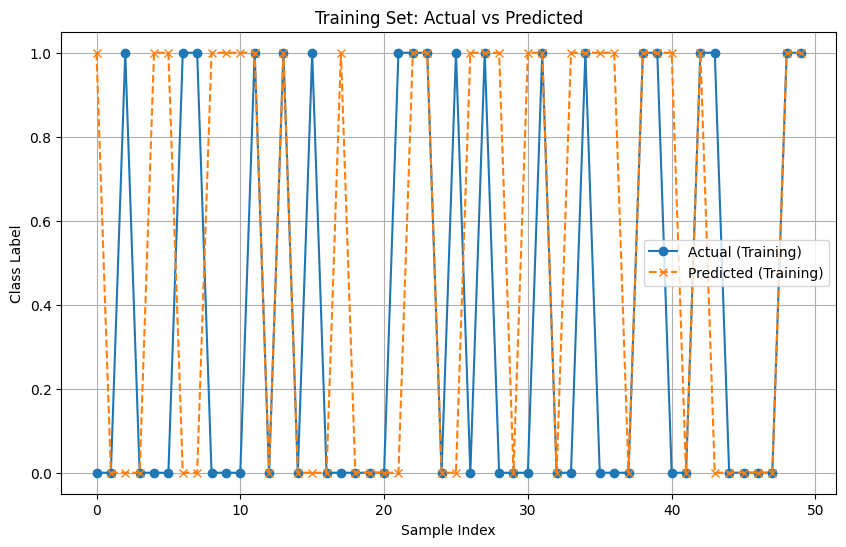

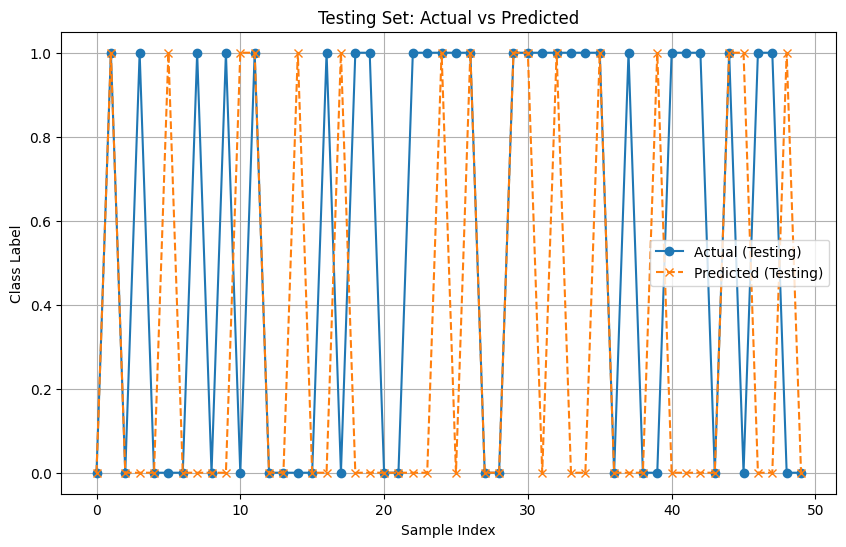

In [37]:
y_train_pred = model.predict(X_train)
y_train_pred_binary = [1 if p >= 0.5 else 0 for p in y_train_pred]

y_test_pred = model.predict(X_test)
y_test_pred_binary = [1 if p >= 0.5 else 0 for p in y_test_pred]

# Plot actual vs. predicted for the training set
plt.figure(figsize=(10, 6))
plt.plot(y_train[:50], label="Actual (Training)", marker='o', linestyle='-')  # First 50 samples
plt.plot(y_train_pred_binary[:50], label="Predicted (Training)", marker='x', linestyle='--')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid()
plt.show()

# Plot actual vs. predicted for the testing set
plt.figure(figsize=(10, 6))
plt.plot(y_test[:50], label="Actual (Testing)", marker='o', linestyle='-')  # First 50 samples
plt.plot(y_test_pred_binary[:50], label="Predicted (Testing)", marker='x', linestyle='--')
plt.title("Testing Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid()
plt.show()

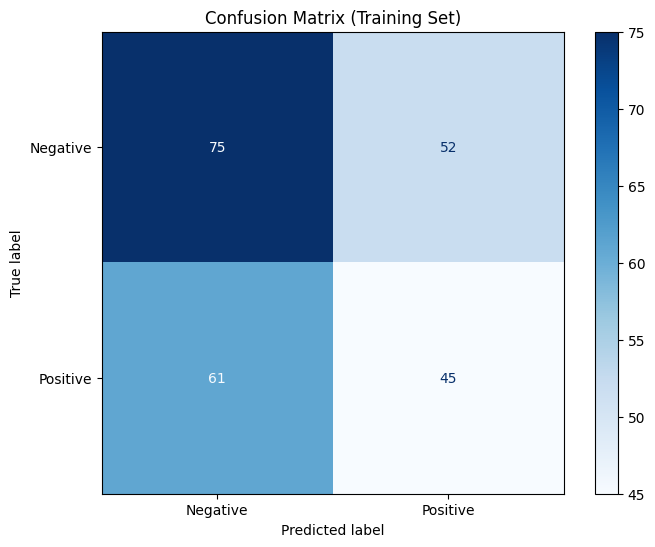

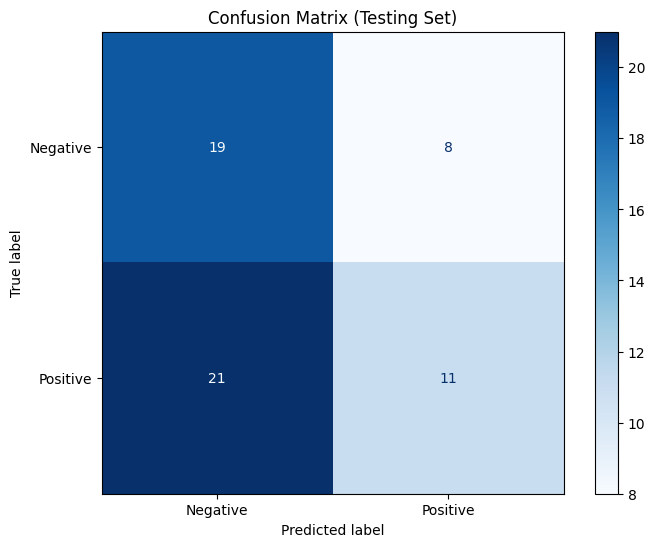

In [39]:
train_cm = confusion_matrix(y_train, y_train_pred_binary)
plt.figure(figsize=(8, 6))
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["Negative", "Positive"])
train_disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Compute and display the confusion matrix for the testing set
test_cm = confusion_matrix(y_test, y_test_pred_binary)
plt.figure(figsize=(8, 6))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["Negative", "Positive"])
test_disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix (Testing Set)")
plt.show()

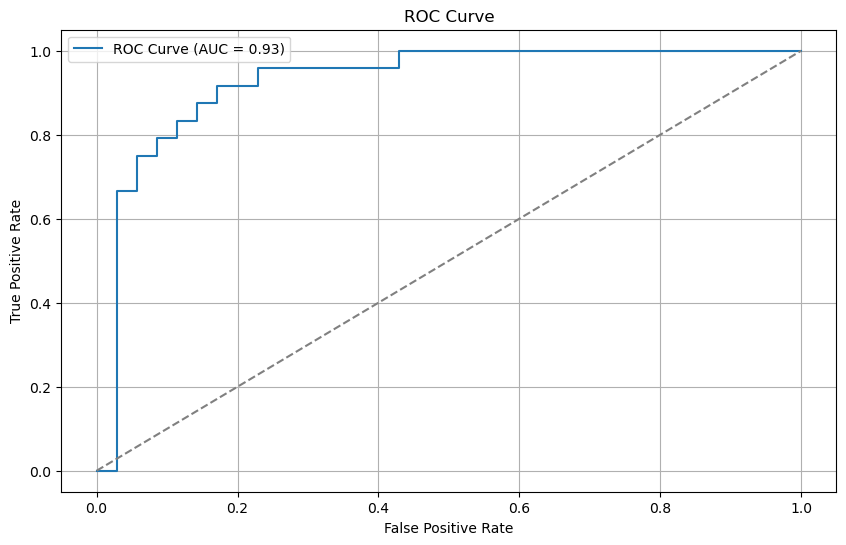

In [41]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [41]:
from sklearn.metrics import classification_report

print("Classification Report (Training):\n", classification_report(y_train, y_train_pred_binary))
print("Classification Report (Testing):\n", classification_report(y_test, y_test_pred_binary))


Classification Report (Training):
               precision    recall  f1-score   support

           0       0.55      0.59      0.57       127
           1       0.46      0.42      0.44       106

    accuracy                           0.52       233
   macro avg       0.51      0.51      0.51       233
weighted avg       0.51      0.52      0.51       233

Classification Report (Testing):
               precision    recall  f1-score   support

           0       0.47      0.70      0.57        27
           1       0.58      0.34      0.43        32

    accuracy                           0.51        59
   macro avg       0.53      0.52      0.50        59
weighted avg       0.53      0.51      0.49        59



In [45]:
model.save('fine_tuned_inception.h5')  